# Explaining Regression Models with SHAP

## Lesson Objectives

- Use SHAP to produce global explanations for regression models.
- Compare nuances in the code for applying shap to different types of regression models.


## Student Performance - Revisited

- We will be revisiting the Portuguese-grade version of the Student Performance Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
## Customization Options

pd.set_option("display.max_columns",100)
plt.style.use(['fivethirtyeight','seaborn-talk'])
mpl.rcParams['figure.facecolor']='white'

## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn import metrics

## fixing random for lesson generation
SEED = 321
np.random.seed(SEED)

In [2]:
## Load in the student performance data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"

df = pd.read_excel(url,sheet_name='student-por')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      649 non-null    object 
 1   sex         649 non-null    object 
 2   age         649 non-null    float64
 3   address     649 non-null    object 
 4   famsize     649 non-null    object 
 5   Pstatus     649 non-null    object 
 6   Medu        649 non-null    float64
 7   Fedu        649 non-null    float64
 8   Mjob        649 non-null    object 
 9   Fjob        649 non-null    object 
 10  reason      649 non-null    object 
 11  guardian    649 non-null    object 
 12  traveltime  649 non-null    float64
 13  studytime   649 non-null    float64
 14  failures    649 non-null    float64
 15  schoolsup   649 non-null    object 
 16  famsup      649 non-null    object 
 17  paid        649 non-null    object 
 18  activities  649 non-null    object 
 19  nursery     649 non-null    o

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,no,no,4.0,3.0,4.0,1.0,1.0,3.0,4.0,0.0,11.0,11.0
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,1.0,1.0,3.0,2.0,9.0,11.0,11.0
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,0.0,yes,no,no,no,yes,yes,yes,no,4.0,3.0,2.0,2.0,3.0,3.0,6.0,12.0,13.0,12.0
3,GP,F,15.0,U,GT3,T,4.0,2.0,health,services,home,mother,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,yes,3.0,2.0,2.0,1.0,1.0,5.0,0.0,14.0,14.0,14.0
4,GP,F,16.0,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,no,no,yes,yes,no,no,4.0,3.0,2.0,1.0,2.0,5.0,0.0,11.0,13.0,13.0


### Predicting Actual G3 Grades


- As a reminder, we had used the G3 column to calculate letter grades, and then built classification models to predict which students would get an F. 

- Let's return to using the original regression target from the beginning of this week: G3. Let's visualize the G3 feature to remember what the target values look like.

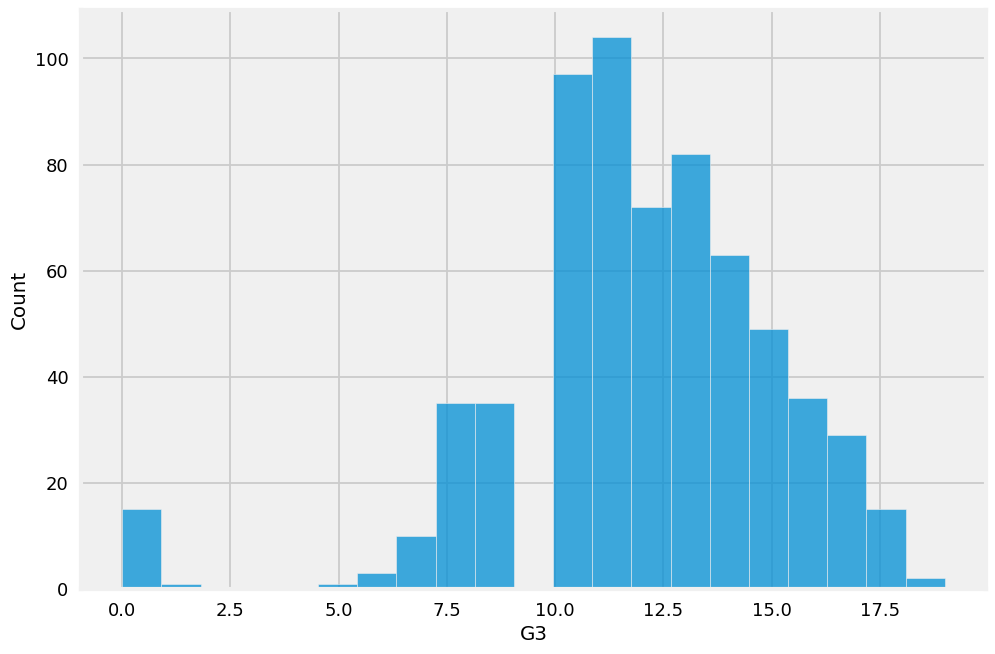

In [3]:
sns.histplot(df['G3']);

### Preprocessing

In [4]:
# ### Train Test Split
## Make x and y variables
drop_feats = ['G1','G2']
y = df['G3'].copy()
X = df.drop(columns=['G3',*drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)

# ### Preprocessing + ColumnTransformer

## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')

## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)

## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
104,15.0,3.0,4.0,1.0,2.0,0.0,5.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
284,18.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,5.0,2.0,5.0,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
579,18.0,1.0,3.0,1.0,1.0,0.0,4.0,3.0,3.0,2.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


## Modeling - RandomForestRegressor

In [5]:
## fit random forest
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)

print(f"Training R^2: {rf_reg.score(X_train_df,y_train):.3f}")
print(f"Test R^2: {rf_reg.score(X_test_df, y_test):.3f}")

Training R^2: 0.892
Test R^2: 0.356


- Now that we have our regression model, let's apply SHAP to explain how it makes its predictions.

## Using SHAP with Regression Models

In [6]:
import shap
shap.initjs()

In [7]:
X_shap = shap.sample(X_train_df, nsamples=200, random_state=321)
X_shap

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
473,16.0,2.0,1.0,2.0,1.0,0.0,2.0,4.0,3.0,2.0,3.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
340,17.0,3.0,3.0,1.0,1.0,0.0,4.0,4.0,3.0,1.0,3.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
452,16.0,2.0,2.0,3.0,2.0,0.0,4.0,4.0,5.0,1.0,1.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
555,16.0,1.0,2.0,1.0,3.0,0.0,4.0,3.0,4.0,1.0,1.0,3.0,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
70,16.0,3.0,1.0,2.0,4.0,0.0,4.0,3.0,2.0,1.0,1.0,5.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,18.0,1.0,4.0,1.0,2.0,0.0,3.0,4.0,4.0,1.0,2.0,5.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
443,15.0,4.0,1.0,1.0,2.0,0.0,5.0,3.0,4.0,1.0,2.0,2.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
120,15.0,1.0,2.0,1.0,2.0,0.0,3.0,2.0,3.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
294,18.0,2.0,2.0,1.0,2.0,0.0,3.0,2.0,3.0,1.0,1.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [8]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap

473    10.0
340    15.0
452    11.0
555    13.0
70     11.0
       ... 
353    11.0
443     8.0
120    14.0
294    13.0
340    15.0
Name: G3, Length: 200, dtype: float64

### Explaining Our RandomForestRegressor with SHAP

- As we did when we explained our RandomForestClassifier when we first introduced shap, we will instantiate an explainer using just the model itself. 

In [9]:
explainer = shap.Explainer(rf_reg)
explainer

- We will then calculate the shap_values by running the explainer as a function with X_shap and y_shap as the arguments.

In [10]:
shap_values = explainer(X_shap,y_shap)
shap_values.shape

(200, 43)

In [11]:
X_shap.shape

(200, 43)

- We can see that the shape of shap values is the same same as our X data. 
    - Unlike the shap values we've seen for classification models, where SHAP would add an additional 3rd dimension for each class, shap values for regression models only produce 1 set of Shap values.
    

- This means we do not need to save a slice of values from our SHAP values before we start creating visualizations- we will use the entire variable.

### Summary Plot

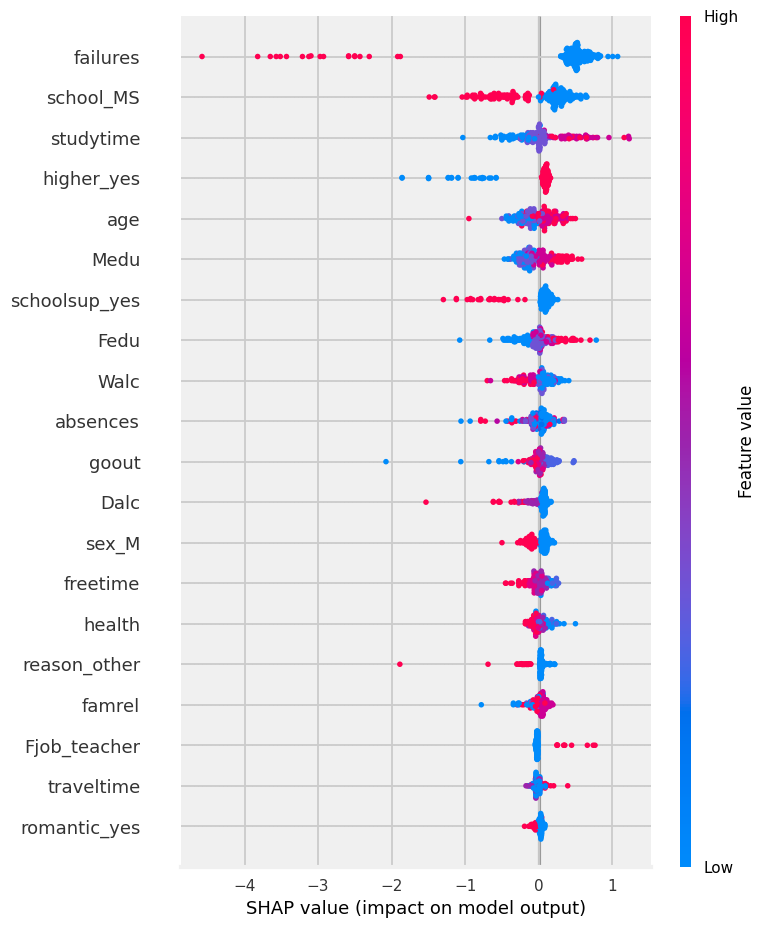

In [12]:
shap.summary_plot(shap_values,X_shap)

#### Global Force Plot

- Since the shap_values have 1 set of values for a egression model. The explainer also has only 1 value for the `explainer.expected_value`.


In [13]:
## Global Force Plot 
shap.force_plot(explainer.expected_value, shap_values.values, features=X_shap)

![png](images/global_force_plot_reg.png)

# Differences Between Regression Model Types

- Just as you saw in the lesson where we compared SHAP usage by classification model types, there are also variations in the syntax for different regression model types.
- The differences between the syntax for using SHAP with different types of Regression models are the same as they were when we compared different classification model types (RandomForestClassifier, LogisticRegression, and KNeigborsClassifier)


### RandomForestRegressor

In [14]:
## fit random forest
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)

print(f"Training R^2: {rf_reg.score(X_train_df,y_train):.3f}")
print(f"Test R^2: {rf_reg.score(X_test_df, y_test):.3f}")

Training R^2: 0.901
Test R^2: 0.344


- When explaining a RandomForestRegressor:
    - We instantiate the explainer using only the model itself.
    - We calculate shap values by running the explainer as a function with X_shap and y_shap as the arguments.
 

In [15]:
explainer = shap.Explainer(rf_reg)
explainer

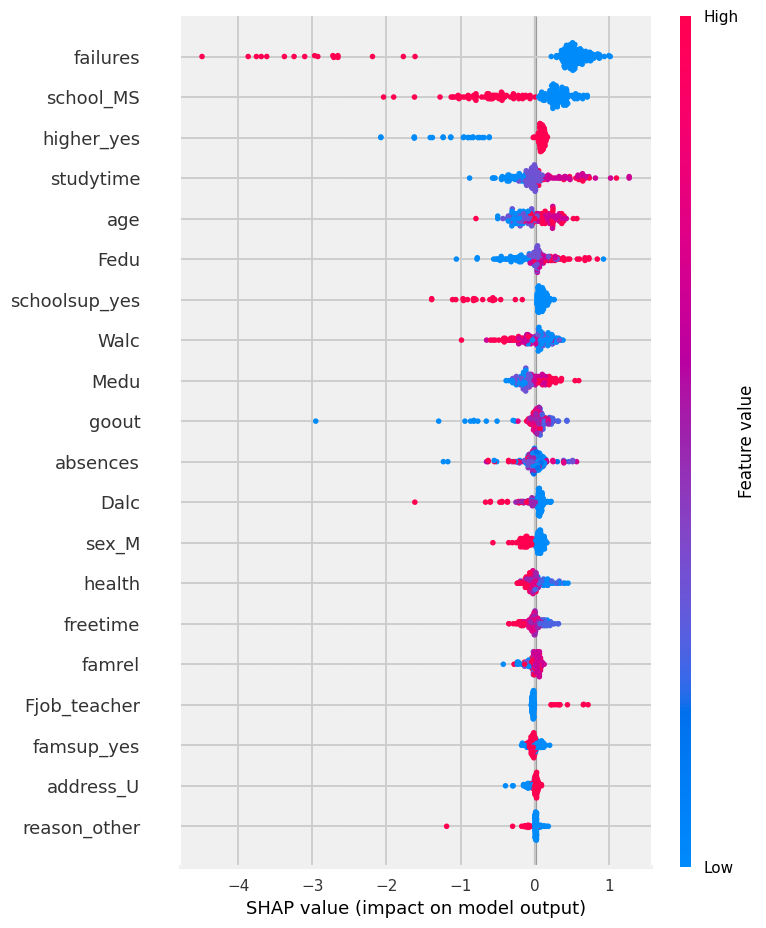

In [16]:
shap_values = explainer(X_shap,y_shap)
shap.summary_plot(shap_values,X_shap)

### LinearRegression

In [17]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)

print(f"Training R^2: {lin_reg.score(X_train_df,y_train):.3f}")
print(f"Test R^2: {lin_reg.score(X_test_df, y_test):.3f}")

Training R^2: 0.350
Test R^2: 0.348


- When explaining a LinearRegression:
    - We instantiate the explainer using the model and X_shap.
    - We calculate shap values by running the explainer as a function with X_shap as the only argument.

In [18]:
linreg_explainer = shap.Explainer(lin_reg, X_shap)
linreg_explainer

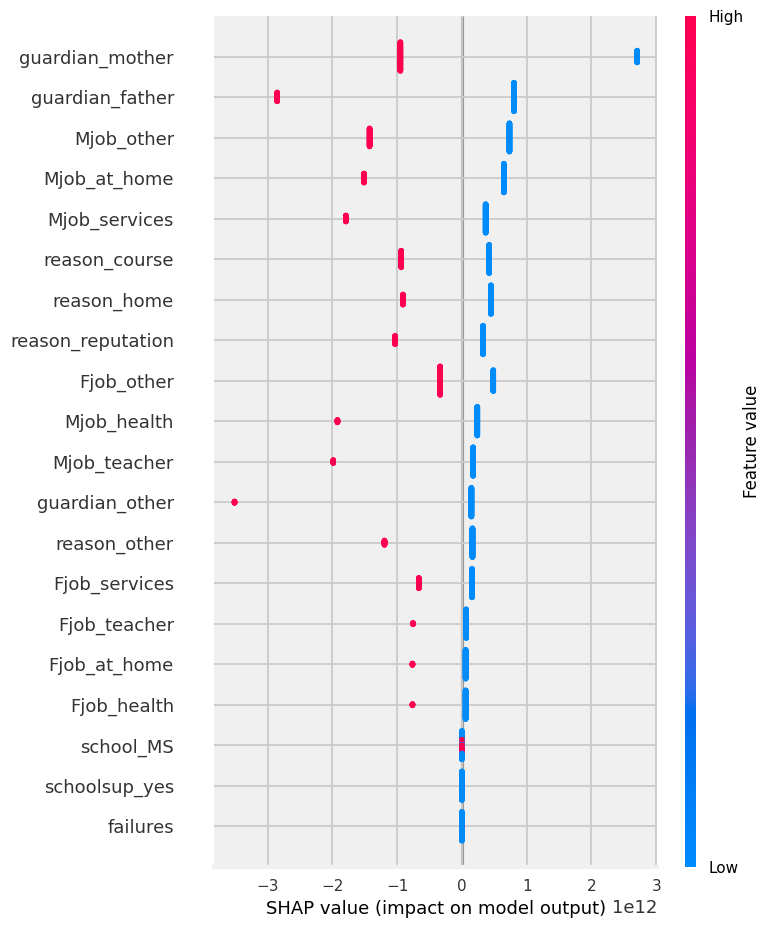

In [19]:
linreg_shap_values = linreg_explainer(X_shap)
shap.summary_plot(linreg_shap_values,X_shap)

### KNN

In [20]:
from sklearn.neighbors import KNeighborsRegressor

In [21]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train_df, y_train)

print(f"Training R^2: {knn_reg.score(X_train_df,y_train):.3f}")
print(f"Test R^2: {knn_reg.score(X_test_df, y_test):.3f}")

Training R^2: 0.396
Test R^2: 0.061


- When explaining a KNeighborsRegressor:
    - We instantiate the explainer using the model's .predict method as the first argument, and X_shap as the second.
    - We calculate shap values by running the explainer as a function with X_shap as the only argument.

In [22]:
explainer_knn = shap.Explainer(knn_reg.predict, X_shap)
explainer_knn

Permutation explainer: 201it [00:15,  4.65it/s]                                 


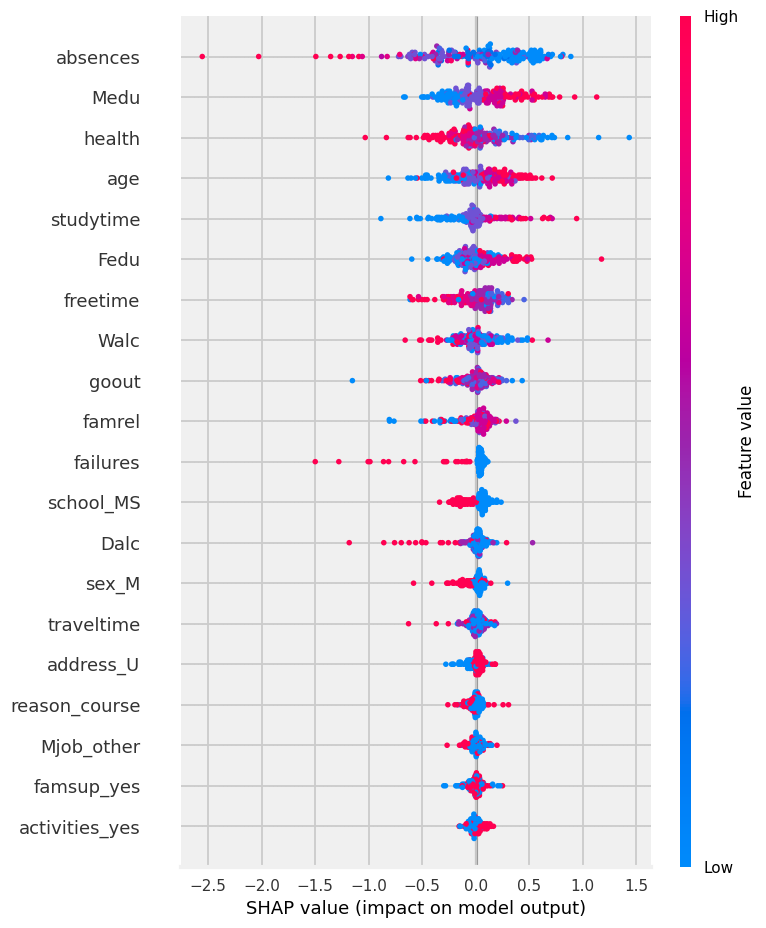

In [23]:
shap_vals_knn = explainer_knn(X_shap)
shap.summary_plot(shap_vals_knn,X_shap)

## Summary

This lessons showed how to apply SHAP model explainers with regression models. It also reviewed the differences between the syntax for using different types of regresssion models with SHAP.

# APPENDIX (move to later lesson)

In [24]:
raise Exception("stop here")

Exception: stop here

### Individual Force Plot

- Since the `explainer.expected_value` only has 1 value, the only slicing that needs to be done for an individual force plot is to slice the same row from the X_shap and shap_values variables.
- Note: in the below example we use the 68th row as the selected example, but you would want to mindfully select the examples. like we did when we first introduced local explanations.

In [ ]:
# Selecting a row
row = 68
row

In [ ]:
print(f"- Row #: {row}")
print(f"- Target: {y_shap.loc[row]}")
X_shap.loc[row].round(2)

In [ ]:
## Individual forceplot
shap.force_plot(explainer.expected_value,
                shap_values= shap_values[row].values,
               features=X_shap.loc[row])

# MOVE TO LIME LESSON 

## Using LIME with Regression Models

- Updating our code to create explanations for Regression Models using LIME is even easier!
- The only major changes are that we will specify the `mode='regression'` when we instantiate the `LimeTabularExplainer`, and we will no longer provide `class_names`, since we no longer have classes.

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
lime_explainer =LimeTabularExplainer(
    training_data=X_shap.values,  
    feature_names=X_shap.columns,
   mode='regression'
)
lime_explainer

In [ ]:
exp = lime_explainer.explain_instance(X_shap.loc[row],
                               rf_reg.predict)
exp.show_in_notebook()

In [ ]:
y_shap.iloc[row]

## Summary


This lesson showed you how to use SHAP and LIME to explain regression models.